## Computational Perception Assignment 2
Brennan McFarland

### Imports

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import pywt
from sklearn.decomposition import PCA, FastICA as ICA
from skimage.color import rgb2gray

### Q1. Entropy (30 points)

1.1 (5 points) Write code to generate $N$ random samples from a 1) a uniform distribution, 2) a normal distribution, and 3) a sparse (leptokurtic) distribution of your choosing (or whatever is available in your the statistics library).  Plot histograms for your samples.

For my leptokurtic distribution, I chose the laplace.

In [243]:
def my_uniform(n, low=0.0, high=1.0):
    return np.array([np.random.uniform(low, high) for _ in range(n)])

def my_normal(n, mu=.5, sigma=.25):
    return np.array([np.random.normal(mu, sigma) for _ in range(n)])

def my_sparse(n, loc=.5, scale=.1):
    return np.array([np.random.laplace(loc, scale) for _ in range(n)])

In [244]:
# test the distributions by matching against numpy functions with the same random seed

def seed_random_constant():
    random.seed(24601) # who am I?
    np.random.seed(24601)

my_funcs = (my_uniform, my_normal, my_sparse)
func_names = ('uniform', 'normal', 'laplace')
np_funcs = (
    np.random.uniform,
    lambda size: np.random.normal(loc=.5, scale=.25, size=size),
    lambda size: np.random.laplace(loc=.5, scale=.1, size=size)
)

n = 5
for func_name, my_func, np_func in zip(func_names, my_funcs, np_funcs):
    seed_random_constant()
    my_output = my_func(n)
    seed_random_constant()
    
    np_output = np_func(size=n)
    difference = my_output - np_output
    #print(func_name, " My output: ",my_output, " Numpy output: ", np_output, " Difference: ", difference)
    assert np.array_equal(my_output, np_output)
print("No assertion failures, all functions equivalent")

No assertion failures, all functions equivalent


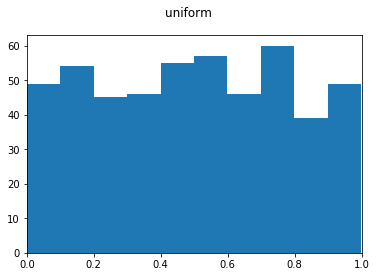

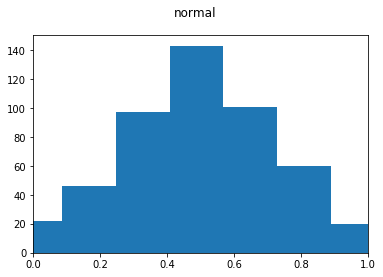

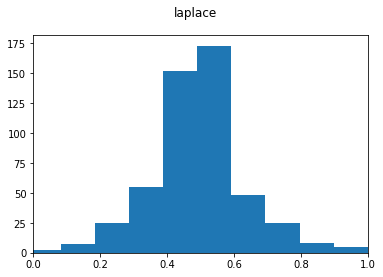

In [246]:
# plot histograms
n=500
for func_name, my_func in zip(func_names, my_funcs):
    histogram = np.histogram(my_func(n))  
    plt.hist(my_func(n))
    plt.xlim((0, 1))
    plt.gcf().suptitle(func_name)
    plt.show()

1.2 (5 points) Write a function that *computes* a histogram (e.g. computes the counts for a set of bins).  You can use library functions (e.g. in [fit(Histogram, ...)](http://juliastats.github.io/StatsBase.jl/latest/empirical.html#Histograms) in julia or [numpy.histogram](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.histogram.html) in python)).  Your bins should be evenly spaced within a range.

In [247]:
def compute_histogram(arr, hist_bins=10, hist_range=(-1, 1)):
    histogram = np.histogram(arr, bins=hist_bins, range=hist_range)
    return histogram

In [248]:
# for good measure, here's a function to plot it
def plot_histogram(histogram):
    plt.bar(histogram[1][:-1], histogram[0]) # we get rid of the last element because we don't need the upper bound of the max
    plt.show()

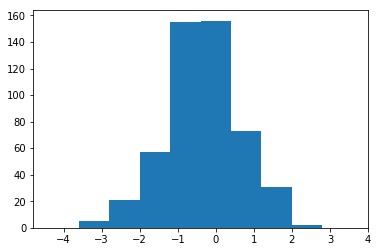

In [249]:
# test the function on a normal distribution
histogram = compute_histogram(np.random.normal(size=500), hist_range=(-4, 4))
plot_histogram(histogram)

1.3 (5 points) Write a function to calculate the entropy

$$
-\sum_x p(x) \log_2 p(x)
$$
given a vector of counts.  It should properly handle bins with zero count. 

In [250]:
# the entropy can of course be >1 because it's not binary
def entropy(counts):
    probs = counts / np.sum(counts)
    log_probs = np.log2(probs)
    entropy = -np.nansum(probs*log_probs) # nansum makes it treat log(0) as 0 (since it returns nan), so 0 counts work
    return entropy

In [251]:
# test on normal distribution
counts = compute_histogram(np.random.normal(size=500), hist_range=(-4, 4))[0]
ent = entropy(counts)
print(ent)

2.3892136823434194


/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


1.4 (5 points) Estimate the entropy using the distributions above, using $2^k$ bins and the same bin boundaries for each.  Explain the differences in the entropy estimates and how they compare to the capacity of a $k$-bit binary code.

In [252]:
k = 5
bins = 2 ** k
n = 1000

for func_name, my_func in zip(func_names, my_funcs):
    counts = compute_histogram(my_func(n), hist_bins=bins, hist_range=(0, 1))[0]
    ent = entropy(counts)
    print(func_name, ent)
print('capacity ', np.log2(n))

uniform 4.984536332963493
normal 4.813968774033491
laplace 4.0031883039158656
capacity  9.965784284662087


/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


As can be seen by the above output, the laplace, normal and uniform functions are in increasing order of entropy.  It makes sense that uniform should have maximum entropy as any value is as probable as any other, therefore we can't reduce the complexity of the signal without losing information.  The normal distribution is next highest entropy because values close to the mean are more probable than those farther out, and so a sampled signal contains some redundancy which can be reduced.  Because the laplace distribution used is leptokurtotic, though, it has less of a spread than the normal distribution, that is, the distribution is more concentrated around the mean, resulting in even more uneven probabilities and thus lower entropy from more signal redundancy close to the mean.  All of these, of course, are less than the capacity, the log base 2 of the number of samples, since this is the absolute maximum information per bit.

1.5 (5 points) Use your function to estimate the entropy of an image (or sound) from the pixels (or samples).

In [263]:
# the range of possible values is 0-1, so we'll calculate entropy over that
def entropy_of_image_file(filename, k=5):
    path = 'data/' + filename
    img = imread(path)
    img = rgb2gray(img)
    img = img.flatten()
    counts = compute_histogram(img, hist_range=(0, 1), hist_bins=2**k)[0]
    ent = entropy(counts)
    return ent

In [264]:
ent = entropy_of_image_file('flam3.png')
print(ent)

3.888385096867215


1.6 (5 points) Find and plot low- and high-entropy examples of images (or sounds).  What type would have the highest entropy?  The lowest?

In [266]:
print('low entropy:')
print(entropy_of_image_file('intro_img.png'))
print('high entropy:')
print(entropy_of_image_file('IMG_0697.JPG'))

low entropy:
1.8982165641679714
high entropy:
4.440872752658658


The lowest entropy images would be all one color, more specifically one shade of gray as the probability of that particular color channel value would be 1 and the probability of any other value would be 0, thus making the entire signal reducable to one value.

Likewise, the highest entropy images would be pure noise, as any color channel value of any pixel would be as likely as any other, which is the uniform distribution and has minimum actual entropy, full of irreducible signal complexity as none of the values are correlated or more frequent than any other.

As such, it makes sense then that my low entropy image, which is almost purely black and white, would be much lower entropy than the high entropy photo, which contains a wider range of grayscale values even when converted to grayscale from color (which was done for comparison to the black and white cartoon).  These image properties are due to the fact that the low entropy image is a black and white cartoon, whereas the high entropy image is a photo of my room when I come home from college, now empirically measured to be in a quantifiable state of disorder.

### Q2. 1D Channel Coding (30 points)


2.1 (5 pts) Write a function that takes a vector of real-valued numbers and quantizes them into $n$ evenly-spaced bins, replacing each with either the bin center value or randomizing the values within the bin.

In [14]:
# replacing each with the bin center value
def quantize(values, n):
    bin_bounds = np.linspace(min(values), max(values), n+1) # the boundaries between bins and the min and max
    bin_centers = [(bin_bounds[i]+bin_bounds[i+1])/2 for i in range(len(bin_bounds)-1)]
    return [bin_centers[next((b for b in range(len(bin_bounds)-1) if bin_bounds[b] > value), 0)-1] for value in values]

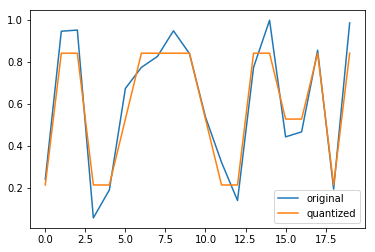

In [361]:
test_signal = np.random.uniform(0, 1, 20)
quantized_test_signal = quantize(test_signal, 3)
plt.plot(test_signal, label='original')
plt.plot(quantized_test_signal, label='quantized')
plt.legend()

2.2 (5 pts) Write another function that takes the quantized values and computes the "reconstruction" error compared to the original signal.

In [362]:
def compute_reconstruction_error(signal, quantized_signal):
    return np.sum(np.abs(signal-quantized_signal))

In [366]:
# test on the test signal
print(compute_reconstruction_error(test_signal, quantized_test_signal))

1.5017073917924775


2.3 (10 points) Write a function that computes a non-linear transform of the data above to minimize the reconstruction error of the quantized, transformed values.  Explain and illustrate your approach.

Since the log function actually works fairly well at representing the original signal, that is what I will use here:

In [421]:
# the log function actually works pretty well, so we'll just use that
def transform_signal(signal_in):
    signal = np.copy(signal_in)
    return np.nan_to_num(np.log2(signal))


def inverse_transform_signal(signal_in):
    signal = np.copy(signal_in)
    return 2 ** signal

It can be seen from the plot and printed output below that performing the log transformation before quantizing (and subsequently its inverse to get back the approximate original signal) leads to a signficantly lower reconstruction error than without transforming the signal, even for as little as 5 bins.  The transformed signal encoding is demonstrated thus to be closer to the original signal than the untransformed encoding.

reconstruction error without transforming:  26.071000866952083
reconstruction error with transforming:  23.753805259466983


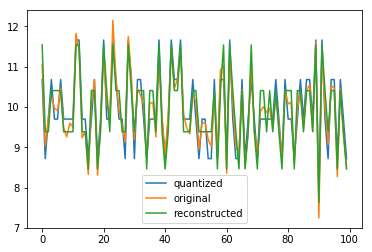

In [372]:
bandwidth = 5
test_signal = np.random.normal(10, 1, 100)

quantized_test_signal = quantize(test_signal, bandwidth)
transformed_test_signal = transform_signal(test_signal)
quantized_transformed_test_signal = quantize(transformed_test_signal, bandwidth)
quantized_reconstructed_test_signal = inverse_transform_signal(quantized_transformed_test_signal)

plt.plot(quantized_test_signal, label='quantized')
plt.plot(test_signal, label='original')
plt.plot(quantized_reconstructed_test_signal, label='reconstructed')
plt.legend()

print("reconstruction error without transforming: ", compute_reconstruction_error(test_signal, quantized_test_signal))
print("reconstruction error with transforming: ", compute_reconstruction_error(test_signal, quantized_reconstructed_test_signal))

2.4 (5 points) Explain how the transform is making optimal use of the capacity of this channel.

We can maximize information transfer over the channel by transforming the signal such that its different output levels are used with equal frequency, meaning that the area under the probability density function of the signal should be evenly divided between bins.  That is to say, the ideal boundary locations between buckets would be at the points on the cumulative distribution where it equals n/N, where n is the bucket order and N is the total number of buckets.  Here though instead of moving the bucket boundaries it is necessary to transform the signal itself to get it more evenly distributed.  The log essentially does this because when the signal is quantized, sharper perturbations of the original signal are lost, but taking the log of the original signal reduces the intensity of these spikes and thus stretches out the buckets over a smaller domain not just objectively (which doesn't matter as the buckets will scale with overall signal magnitude) but also relative to the less prominent signal spikes less affected by the logarithm transform.  This results in values for the bucket means of the transformed signal that when transformed back to the original signal more closely reproduce the spikes, leading to less reconstruction error.

2.5 (5 points) Use this function to illustrate coding of the low- and high-entropy signals you used in the previous question.

In [422]:
def entropy_of_image_file(filename, k=5):
    path = 'data/' + filename
    img = imread(path).flatten()
    img = transform_signal(img)
    img = quantize(img, 2**k)
    err = compute_reconstruction_error(img)
    return err

In [426]:
print('low entropy:')
path = 'data/IMG_0697.JPG'
img = imread(path).flatten()
transformed_img = transform_signal(img)
quantized_transformed_img = quantize(transformed_img, 5)
quantized_reconstructed_img = inverse_transform_signal(quantized_transformed_img)
print('reconstruction error: ', compute_reconstruction_error(img, quantized_reconstructed_img))

print('high entropy:')
path = 'data/intro_img.png'
img = imread(path).flatten()
transformed_img = transform_signal(img)
quantized_transformed_img = quantize(transformed_img, 5)
quantized_reconstructed_img = inverse_transform_signal(quantized_transformed_img)
print('reconstruction error: ', compute_reconstruction_error(img, quantized_reconstructed_img))

low entropy:


/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


reconstruction error:  3023458591.0
high entropy:
reconstruction error:  87475.44142108479


### Q3. Coding with Basis Functions (25 points)

3.1 (5 points) Find a toolbox / package for computing 2D wavelet transforms.  Plot the wavelet transform for your images above (or 1D wavelet if you used sounds).  You can either Haar or Daubechies wavelets, but feel free to explore others.

I used the pywavelet package to compute the 2D wavelet transform of my images with the Haar wavelet.

In [318]:
def wavelet_of_image_file(filename, k=5):
    path = 'data/' + filename
    img = imread(path)
    img = rgb2gray(img)
    cwtA, cwtD = pywt.dwt2(img, 'haar') # I'm using pywavelet, because it's nice and lightweight and scipy doesn't do discrete
    return cwtA # CWA, being the approximation coeffs, is what we care about

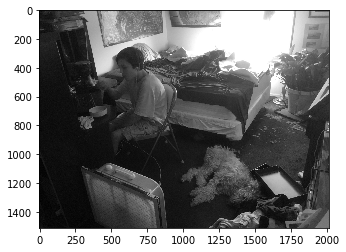

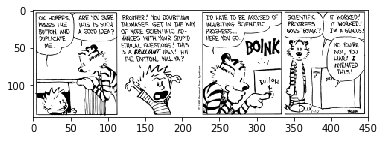

In [324]:
wavelet_1 = wavelet_of_image_file('IMG_0697.JPG')
wavelet_2 = wavelet_of_image_file('intro_img.png')

plt.imshow(wavelet_1, cmap='gray')
plt.show()
plt.imshow(wavelet_2, cmap='gray')
plt.show()

3.2 (10 points) Write a function to plot the wavelet basis functions by apply the inverse transform to delta function in the coeficients.  Use a small (e.g. 8x8 or 16x16) image to limit the number of basis functions you have to plot.

As expected, the wavelet basis functions are a collection of point features and horizontal, vertical and diagonal "edge detectors" (of the kind which are not actually edge detectors but the first layer of filters which could be composed into edge detectors):

In [276]:
def plot_wavelet_basis_functions(coeffs):
    coeffs = (np.zeros(shape=coeffs[0].shape), (np.zeros(shape=coeffs[1][0].shape), np.zeros(shape=coeffs[1][1].shape), np.zeros(shape=coeffs[1][2].shape)))
    cwtA, cwtD = coeffs[0], coeffs[1]
    cwts = (cwtA, cwtD[0], cwtD[1], cwtD[2])
    for c, cwt in enumerate(cwts):
        for r, cwt_row in enumerate(cwt):
            for v, cwt_coeff in enumerate(cwt_row):
                cwts[c][r][v] = 1.0
                basis_functions = pywt.idwt2(coeffs, 'haar')
                plt.imshow(basis_functions, cmap='gray')
                plt.show()
                cwts[c][r][v] = 0.0

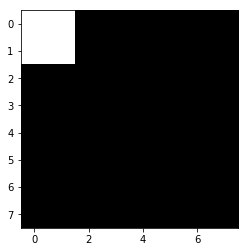

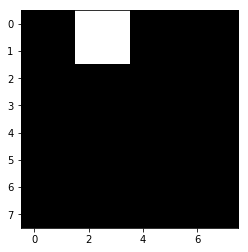

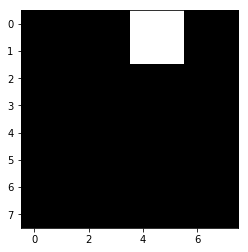

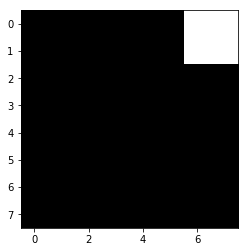

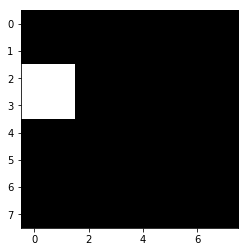

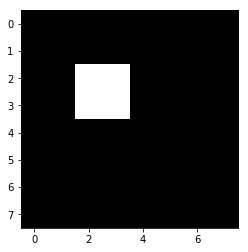

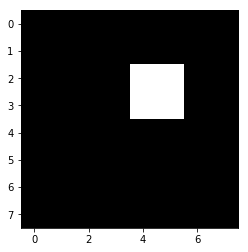

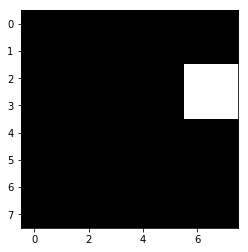

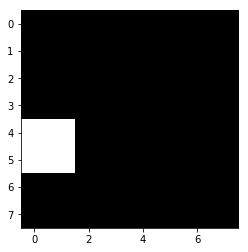

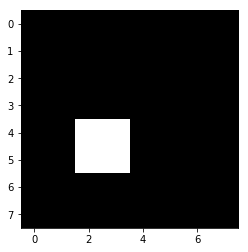

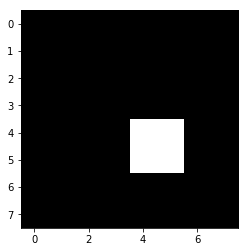

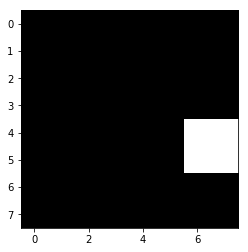

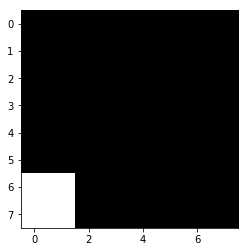

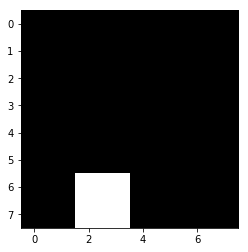

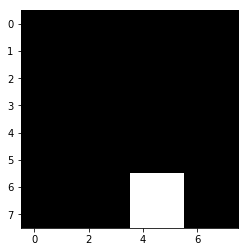

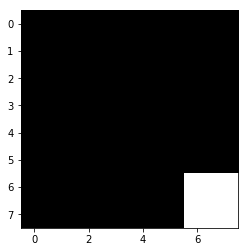

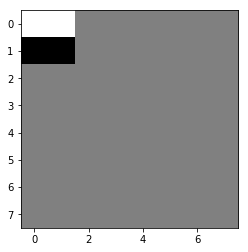

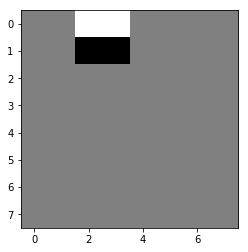

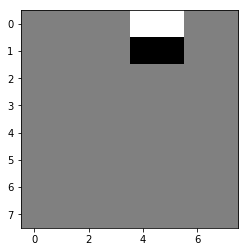

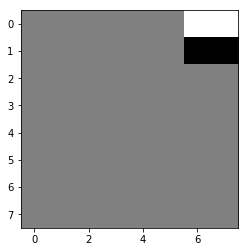

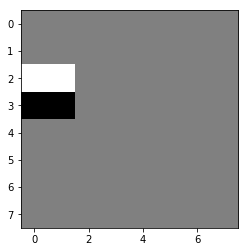

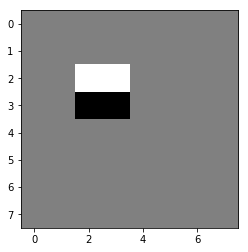

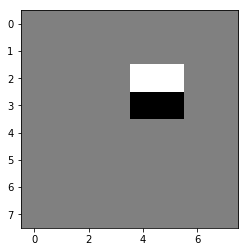

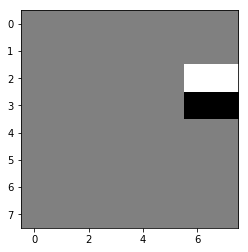

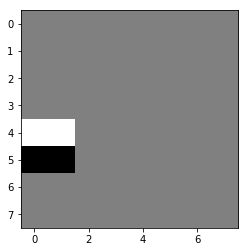

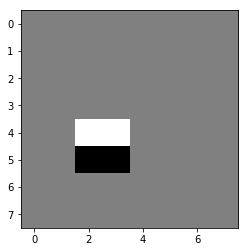

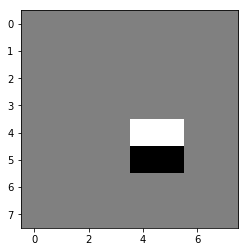

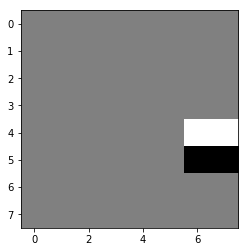

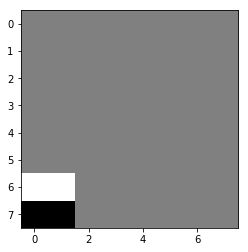

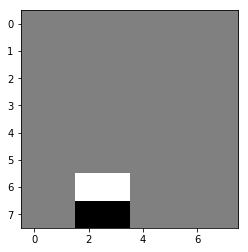

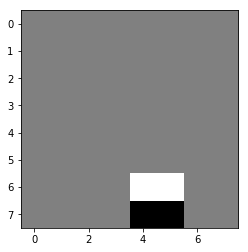

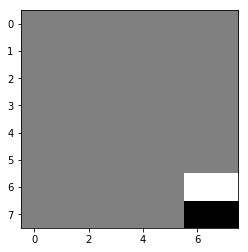

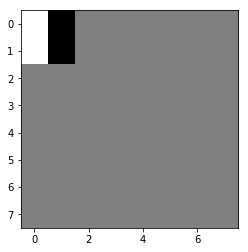

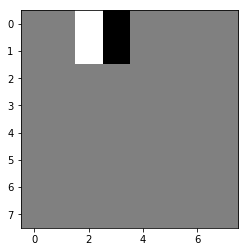

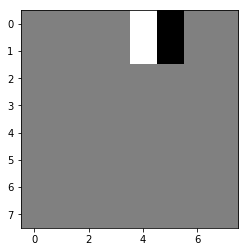

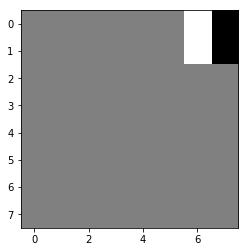

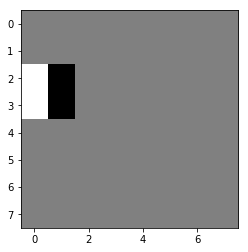

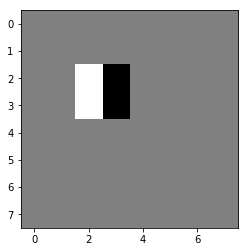

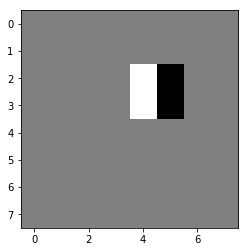

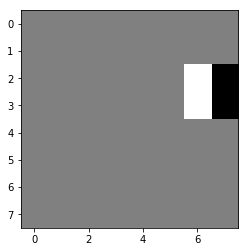

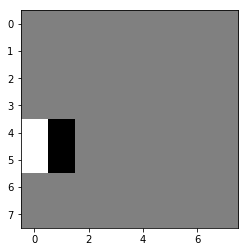

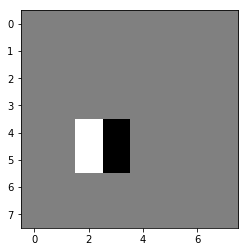

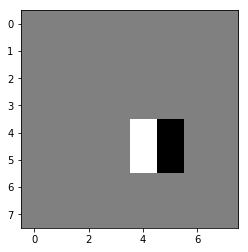

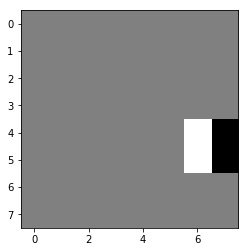

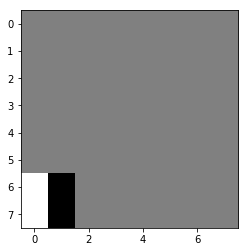

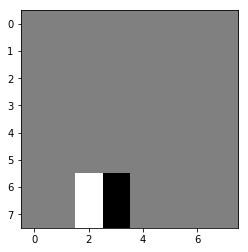

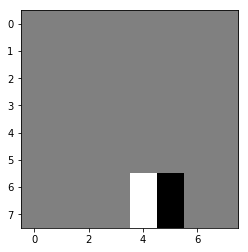

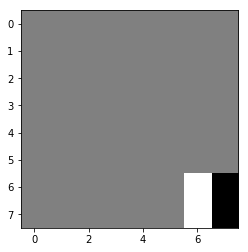

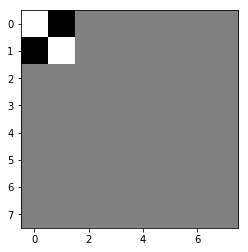

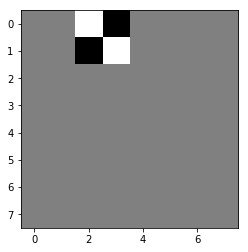

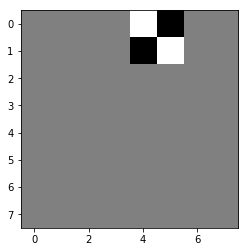

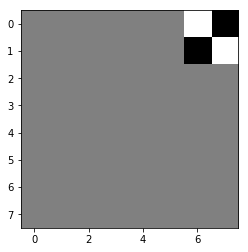

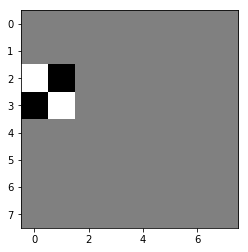

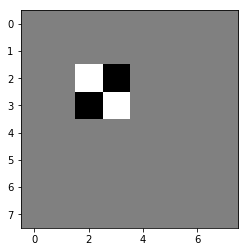

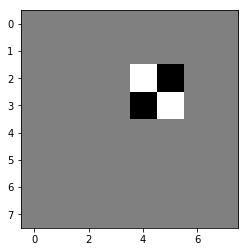

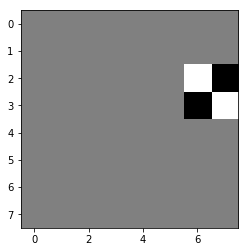

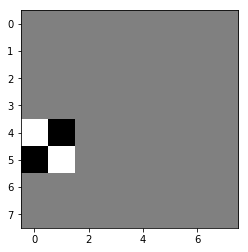

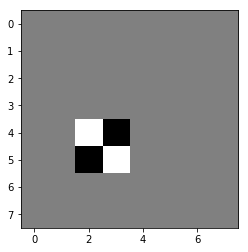

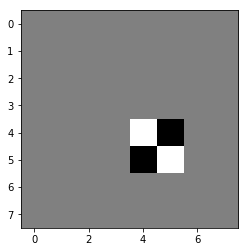

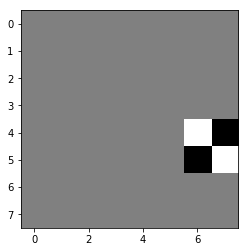

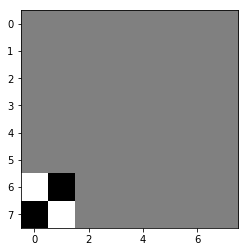

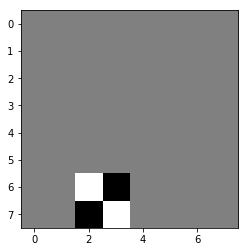

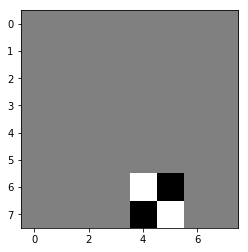

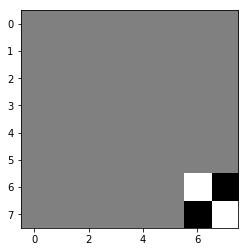

In [376]:
path = 'data/face.png'
img = imread(path)
img = rgb2gray(img)
cwtA, cwtD = pywt.dwt2(img, 'haar')
plot_wavelet_basis_functions((cwtA, cwtD))

3.3 (10 points) Apply your quantization coding functions above to the wavelet coefficients and illustrate how this code compares to coding the quantized pixels.

In [413]:
# apply quantization to wavelet coefficients
bandwidth = 5
q_cwtA, q_cwtD = quantize(cwtA.flatten(), bandwidth), [quantize(c.flatten(), bandwidth) for c in cwtD]
# need to unflatten the coeffs
q_cwtA = np.array(q_cwtA).reshape((4, 4))
q_cwtD = (np.array(q).reshape((4, 4)) for q in q_cwtD)

reconstructed_img = pywt.idwt2((q_cwtA, q_cwtD), 'haar')
wavelet_err = compute_reconstruction_error(reconstructed_img.flatten(), img.flatten())

# compare to coding quantized pixels directly
q_img = quantize(img.flatten(), bandwidth)
pixel_err = compute_reconstruction_error(img.flatten(), q_img)

print('Pixel reconstruction error: ', pixel_err)
print('Wavelet reconstruction error: ', wavelet_err)

Pixel reconstruction error:  6.399999999999999
Wavelet reconstruction error:  4.999999999999982


It can be seen from the above that the quantized wavelet transform has significantly less reconstruction error than the quantized original pixels, indicating that the wavelet transform creates a more robust and signal encoding.

### Q4. Exploration (15 points)

In this section, you are meant to do creative exploration.  Select a concept or topic you want to understand better that is related to the problems in this assignment or is in the readings.  Explore it, and write up and illustrate what you tried and learned.  The general idea is for you to teaching yourself, and it should read like a (relatively brief) tutorial.

Here I compare a few different signal encoding schemes, namely PCA, ICA and Wavelet Transform, in terms of their entropy and reconstruction loss for different signal bandwidth constraints (number of parameters of the signal).

In [331]:
path = 'data/flam3.png'
img = imread(path)
img = rgb2gray(img) # convert to grayscale to make it run faster and work better with sklearn
print(img.shape)

(1080, 1920)


I create one encoder class for each encoding scheme, all of which are decodable via an inverse transform.  The PCA and ICA functions themselves I imported from sklearn.  The bandwidth parameter for PCA and ICA allows for specifying the number of signal components that can fit across a channel, analogous to the signal constraints imposed when transmitting retinal activations over the optic nerve.

In [332]:
class PCAEncoder:
    
    label = 'PCA'
    
    def __init__(self, bandwidth):
        self.pca = PCA(n_components=bandwidth)
    
    def encode(self, x):
        return self.pca.fit_transform(x)
    
    def decode(self, x):
        return self.pca.inverse_transform(x)


class ICAEncoder:
    
    label = 'ICA'
    
    def __init__(self, bandwidth):
        self.ica = ICA(n_components=bandwidth)
    
    def encode(self, x):
        return self.ica.fit_transform(x)
    
    def decode(self, x):
        return self.ica.inverse_transform(x)


class WaveletEncoder:
    
    label = 'Wavelet'
    
    def __init__(self, bandwidth):
        pass
    
    def encode(self, x):
        self.cA, self.cD = pywt.dwt2(x, 'haar')
        return self.cA
    
    def decode(self, x):
        return pywt.idwt2((x, self.cD), 'haar')

# NOTE: we can't easily parameterize the discrete wavelet transform well to fit a given signal bandwidth
encoder_types = [PCAEncoder, ICAEncoder, WaveletEncoder]

Next I compute the reconstruction loss over entropy as a function of different signal bandwidths (except for Wavelet), printing their values below for verification...

In [341]:
# plot reconstruction loss over entropy
reconstruction_losses = []
entropies = []

for encoder_type in encoder_types:
    print(encoder_type.label)
    reconstruction_losses.append([])
    entropies.append([])
    for bandwidth in (10, 25, 50):
        encoder = encoder_type(bandwidth)
        encoded = encoder.encode(img)
        decoded = encoder.decode(encoded)
        reconstruction_loss = np.sum(abs(np.square(img) - np.square(decoded)))
        reconstruction_losses[-1].append(reconstruction_loss)
    
        counts = compute_histogram(encoded, hist_range=(-4, 4))[0]
        ent = entropy(counts)
        print('bandwidth: ', bandwidth, ' reconstruction loss: ', reconstruction_loss, ' entropy: ', ent)
        entropies[-1].append(ent)

PCA
bandwidth:  10  reconstruction loss:  61692.964753053966  entropy:  2.674826424678941
bandwidth:  25  reconstruction loss:  46642.612285010204  entropy:  2.1494464764688623
bandwidth:  50  reconstruction loss:  33764.838043580785  entropy:  1.7565077806006586
ICA


/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
/home/iamroot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


bandwidth:  10  reconstruction loss:  61692.91478467516  entropy:  0.997975618738544
bandwidth:  25  reconstruction loss:  46641.20623170208  entropy:  0.9970296267045743
bandwidth:  50  reconstruction loss:  33762.98083404486  entropy:  0.999977138407208
Wavelet
bandwidth:  10  reconstruction loss:  7.580874531473112e-11  entropy:  0.5941853674424047
bandwidth:  25  reconstruction loss:  7.580874531473112e-11  entropy:  0.5941853674424047
bandwidth:  50  reconstruction loss:  7.580874531473112e-11  entropy:  0.5941853674424047


... and plotting them as follows:

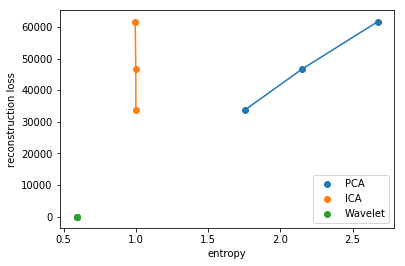

In [133]:
for e, encoder_type in enumerate(encoder_types):
    plt.scatter(entropies[e], reconstruction_losses[e], label=encoder_type.label)
    plt.plot(entropies[e], reconstruction_losses[e])
    plt.legend()
    plt.xlabel('entropy')
    plt.ylabel('reconstruction loss')

plt.show()

From the graph it can be seen that the entropy for ICA is more or less fixed for greater signal bandwidths, meaning that the encoding is making mostly the same level of use of whatever capacity it's given, and as such more bandwidth decreases the reconstruction loss by giving the algorithm more parameters to work with.  PCA, by contrast, has higher entropy for approximately the same reconstruction loss, but entropy and reconstruction loss are more or less linearly correlated.  The wavelet function, of course, since it outputs the same number of coefficients as the pixels it receives and is not truncated, has far more redundancy and lower entropy than either PCA or ICA but far superior (less) reconstruction loss, and it was demonstrated in 3.1 that its reconstruction is essentially indistinguishable from the original.